<a href="https://colab.research.google.com/github/hyunj941031/Submit/blob/main/AI_15_%EC%A0%95%ED%98%84%EC%A4%80_Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install --upgrade xgboost


import xgboost
import warnings

warnings.filterwarnings("ignore")
# xgboost.config.set_config(verbosity=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.9 MB/s 
     |████████████████████████████████| 133 kB 42.2 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=d2d63dd25ff8841c7e9730db9c0f40564e347d911478095ef4a6b1941cb4cffe
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 46 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/disease_diagnosis/Training.csv')
train = train.iloc[:, :-1]

test = pd.read_csv('/content/drive/MyDrive/disease_diagnosis/Testing.csv')

df = pd.concat([train,test])
train.shape, test.shape, df.shape

((4920, 133), (42, 133), (4962, 133))

In [26]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    train, train_size=0.80, test_size=0.20, random_state=2
)
train, val = train_test_split(
    train, train_size=0.80, test_size=0.20, random_state=2
)

train.shape, val.shape, test.shape

((3148, 133), (788, 133), (984, 133))

In [5]:
def divide_data(df):
    X = None
    y = None

    target = 'prognosis'
    ni_columns = ["indigestion", "pain_behind_the_eyes", "fluid_overload.1", "ulcers_on_tongue", "cold_hands_and_feets", "lethargy",
                  "phlegm", "redness_of_eyes", "sinus_pressure", "runny_nose", "pain_during_bowel_movements", "cramps", "swollen_blood_vessels",
                  "puffy_face_and_eyes", "loss_of_smell", "blood_in_sputum", "vomiting", "fatigue", "sweating", "headache", "nausea", "fluid_overload",
                  "malaise", "blurred_and_distorted_vision", "obesity", "excessive_hunger", "swelling_joints",
                  "movement_stiffness", "spinning_movements", "distention_of_abdomen", "painful_walking", "blackheads", "scurring"]
    features = train.drop(columns=[target]+ni_columns).columns

    X = df[features]
    y = df[target]
    
    return X, y

In [27]:
from sklearn.preprocessing import LabelEncoder

X_train, y_train = divide_data(train)
X_val, y_val = divide_data(val)
X_test, y_test = divide_data(test)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(3148, 99) (3148,) (788, 99) (788,) (984, 99) (984,)


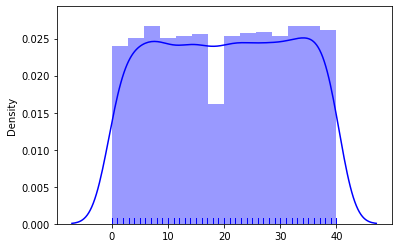

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

di = y_train
sns.distplot(di, color='b', kde=True, rug=True)
plt.show()

In [9]:
X_train.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'muscle_wasting', 'burning_micturition', 'spotting_ urination',
       'weight_gain', 'anxiety', 'mood_swings', 'weight_loss', 'restlessness',
       'patches_in_throat', 'irregular_sugar_level', 'cough', 'high_fever',
       'sunken_eyes', 'breathlessness', 'dehydration', 'yellowish_skin',
       'dark_urine', 'loss_of_appetite', 'back_pain', 'constipation',
       'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine',
       'yellowing_of_eyes', 'acute_liver_failure', 'swelling_of_stomach',
       'swelled_lymph_nodes', 'throat_irritation', 'congestion', 'chest_pain',
       'weakness_in_limbs', 'fast_heart_rate', 'pain_in_anal_region',
       'bloody_stool', 'irritation_in_anus', 'neck_pain', 'dizziness',
       'bruising', 'swollen_legs', 'enlarged_thyroid', 'brittle_nails',
       'swollen_extremeties', 'extra_marital_con

In [10]:
import sklearn
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, Trials, STATUS_OK
from hyperopt import hp
from sklearn.metrics import mean_squared_error

def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

params = {
    "n_estimators": hp.quniform("n_estimators",50, 300, 50),
    "max_depth": hp.quniform("max_depth", 2, 10, 2),
    "max_features": hp.choice("max_features",['auto', 'sqrt', 'log2', None]),
    "min_samples_leaf": hp.uniform("min_samples_leaf", 0, 0.5),
}

def objective(params):
    model = RandomForestClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=params['max_depth'],
            max_features=params['max_features'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=2
            )
    
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = RMSE(y_val, pred)

    return {'loss': rmse, 'status': STATUS_OK, 'model': model}

trials = (
    Trials()
)

best_params = fmin(
    fn=objective, trials=trials, space=params, algo=tpe.suggest, max_evals=50
)

100%|██████████| 50/50 [00:55<00:00,  1.11s/it, best loss: 0.0]


In [11]:
best_params

{'max_depth': 10.0,
 'max_features': 2,
 'min_samples_leaf': 0.011092788865826084,
 'n_estimators': 300.0}

In [12]:
trials.best_trial['misc']['vals']

{'max_depth': [10.0],
 'max_features': [2],
 'min_samples_leaf': [0.011092788865826084],
 'n_estimators': [300.0]}

In [13]:
trials.best_trial['result']

{'loss': 0.0,
 'status': 'ok',
 'model': RandomForestClassifier(max_depth=10.0, max_features='log2',
                        min_samples_leaf=0.011092788865826084, n_estimators=300,
                        random_state=2)}

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def eval_models(y_pred, y_real) :
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)

    return mse, rmse, mae, r2

In [32]:
if best_params['max_features'] == 0:
    model = RandomForestClassifier(
        n_estimators=int(best_params['n_estimators']),
        max_depth=best_params['max_depth'],
        # max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=2
        )
else:
    model = RandomForestClassifier(
        n_estimators=int(best_params['n_estimators']),
        max_depth=best_params['max_depth'],
        max_features=best_params['max_features'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=2
        )
    
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=5)

cv_result = []
for train_idx, test_idx in kf.split(X_train) :
    X_train_temp = pd.DataFrame(X_train)
    y_train_temp = pd.DataFrame(y_train)

    X_train_cv, X_val_cv = X_train_temp.iloc[train_idx], X_train_temp.iloc[test_idx]
    y_train_cv, y_val_cv = y_train_temp.iloc[train_idx], y_train_temp.iloc[test_idx]

    model.fit(X_train_cv, y_train_cv)

    y_pred_cv = model.predict(X_val_cv)

    acc_cv = accuracy_score(y_val_cv, y_pred_cv).round(2)
    cv_result.append(acc_cv)

print('mae for each fold : ', cv_result)
print('average mae for model : ', np.mean(cv_result).round(2))
print('std of result : ', np.std(cv_result).round(2))


mae for each fold :  [1.0, 1.0, 1.0, 1.0, 1.0]
average mae for model :  1.0
std of result :  0.0


In [28]:
# model.fit(X_train, y_train)
pred = model.predict(X_val)

rf_mse, rf_rmse, rf_mae, rf_r2 = eval_models(pred, y_val)

In [29]:
train_pred = model.predict(X_train)

tr_mse, tr_rmse, tr_mae, tr_r2 = eval_models(train_pred, y_train)
tr_mse, tr_rmse, tr_mae, tr_r2

(0.4552096569250318,
 0.674692268315735,
 0.04542566709021601,
 0.9967514929487016)

In [30]:
test_pred = model.predict(X_test)

te_mse, te_rmse, te_mae, te_r2 = eval_models(test_pred, y_test)
te_mse, te_rmse, te_mae, te_r2

(1.1300813008130082,
 1.0630528212713648,
 0.09349593495934959,
 0.9918435868717654)

In [31]:
from scipy import stats as st

base = st.mode(y_train)[0]
baseline = len(y_val) * [base]

base_mse, base_rmse, base_mae, base_r2 = eval_models(baseline, y_val)

comparison_metrics = pd.DataFrame(index=['mse', 'rmse', 'mae', 'r2'])
comparison_metrics['base'] = [base_mse, base_rmse, base_mae, base_r2]
comparison_metrics['train_rf'] = [tr_mse, tr_rmse, tr_mae, tr_r2]
comparison_metrics['val_rf'] = [rf_mse, rf_rmse, rf_mae, rf_r2]
comparison_metrics['test_rf'] = [te_mse, te_rmse, te_mae, te_r2]
comparison_metrics

,base,train_rf,val_rf,test_rf
mse,378.654822,0.455210,0.645939,1.130081
rmse,19.459055,0.674692,0.803703,1.063053
mae,15.934010,0.045426,0.059645,0.093496
r2,-1.690085,0.996751,0.995411,0.991844


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

def get_permutation_importance(X, y, model):
    permuter = PermutationImportance(
        model,
        scoring="accuracy",
        n_iter=5,
        random_state=42,
    )
    
    permuter.fit(X, y)

    return permuter

In [ ]:
permuter = get_permutation_importance(X_test, y_test, model)
eli5.show_weights(permuter, top=None, feature_names=X_test.columns.tolist())

Weight,Feature
0.0262 ± 0.0045,breathlessness
0.0242 ± 0.0008,pus_filled_pimples
0.0157 ± 0.0030,family_history
0.0136 ± 0.0055,muscle_pain
0.0128 ± 0.0046,mild_fever
0.0118 ± 0.0028,weakness_of_one_body_side
0.0116 ± 0.0052,loss_of_balance
0.0112 ± 0.0026,cough
0.0100 ± 0.0033,muscle_weakness
0.0096 ± 0.0024,rusty_sputum


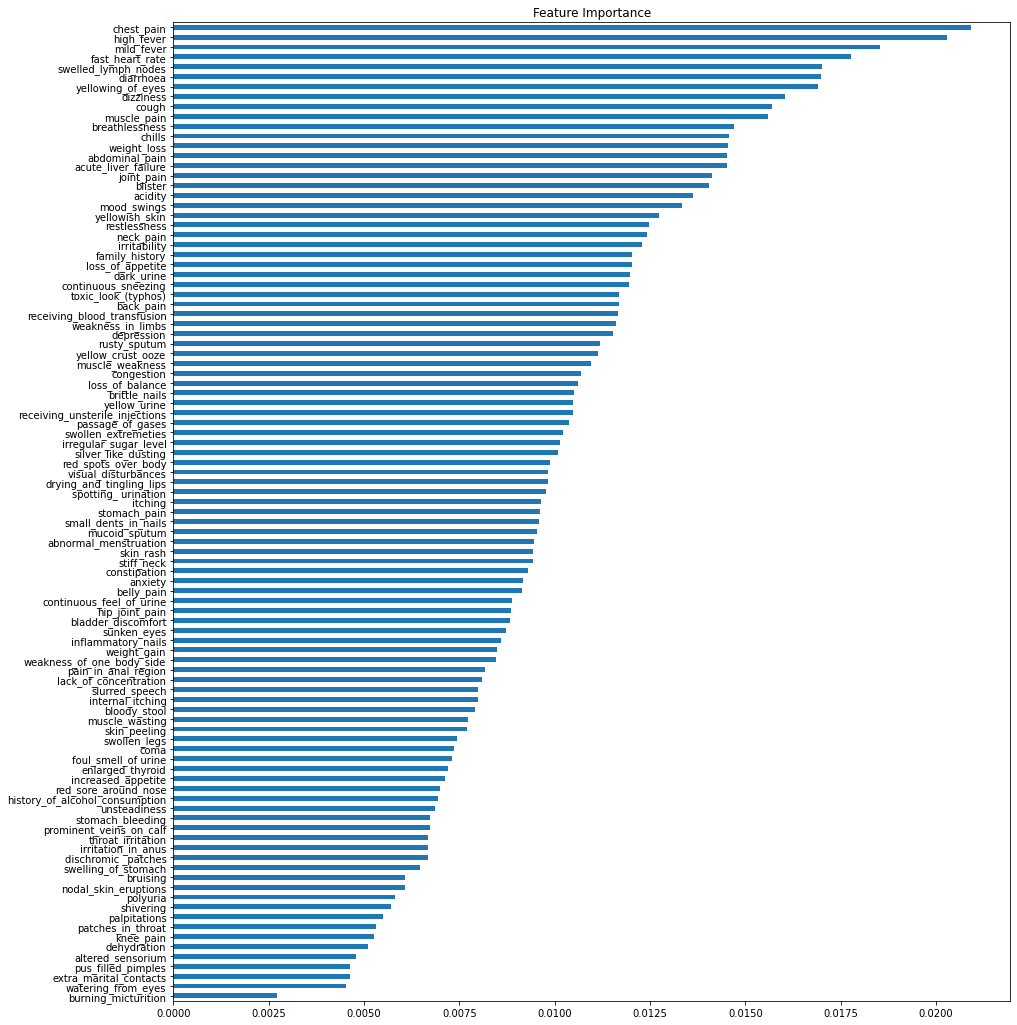

In [ ]:
importances = pd.Series(model.feature_importances_, X_train.columns)
plt.figure(figsize=(15,18))
importances.sort_values().plot.barh()

plt.title("Feature Importance")
plt.show()

In [7]:
plt.figure(figsize=(15,18))
X_train.nunique().sort_values().plot.barh()
plt.title("Cardinailty")

NameError: ignored

In [ ]:
p_i = sorted(
    list(zip(X_test.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
p_i

[('breathlessness', 0.026219512195121954),
 ('pus_filled_pimples', 0.024186991869918704),
 ('family_history', 0.015650406504065063),
 ('muscle_pain', 0.013617886178861772),
 ('mild_fever', 0.012804878048780477),
 ('weakness_of_one_body_side', 0.011788617886178843),
 ('loss_of_balance', 0.011585365853658524),
 ('cough', 0.011178861788617867),
 ('muscle_weakness', 0.009959349593495958),
 ('rusty_sputum', 0.009552845528455301),
 ('lack_of_concentration', 0.008536585365853666),
 ('altered_sensorium', 0.008333333333333326),
 ('diarrhoea', 0.008130081300813007),
 ('spotting_ urination', 0.007520325203252032),
 ('stomach_pain', 0.007317073170731714),
 ('brittle_nails', 0.007317073170731714),
 ('depression', 0.007317073170731714),
 ('mucoid_sputum', 0.007317073170731691),
 ('receiving_unsterile_injections', 0.0069105691056910775),
 ('itching', 0.006910569105691056),
 ('toxic_look_(typhos)', 0.006707317073170738),
 ('abnormal_menstruation', 0.0065040650406504195),
 ('red_spots_over_body', 0.005

In [ ]:
not_imp = p_i[-4:]

for i in range(len(not_imp)):
    print(not_imp[i][0], end='", "')

dizziness", "drying_and_tingling_lips", "prominent_veins_on_calf", "red_sore_around_nose", "

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

def get_pdp_isolated(dataset, model, feature):
    pdp_isolated = None

    pdp_isolated = pdp_isolate(
        model=model,
        dataset=dataset,
        model_features=dataset.columns,
        feature=feature,
        grid_type="percentile",
        num_grid_points=10,
    )

    return pdp_isolated

(<Figure size 1080x11340 with 42 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5dfedc2d90>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x7f5dfed5f290>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f5dff3ee810>]})

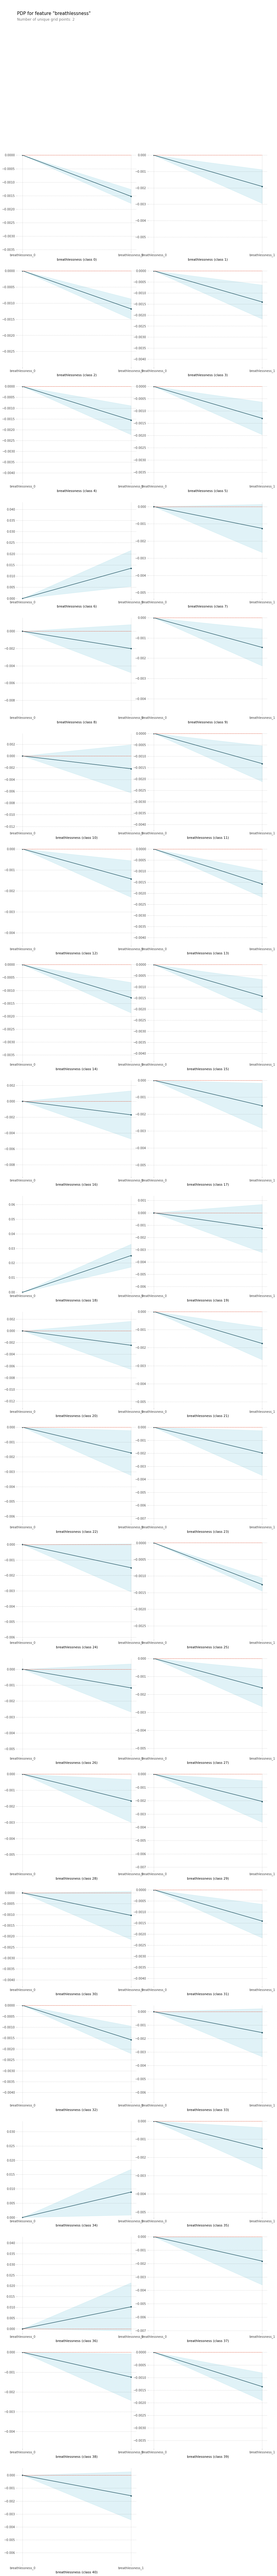

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)
feature = sorted(p_i, key=lambda x: x[1], reverse=True)[0][0]
pdp_isolated = get_pdp_isolated(X_test_df, model, feature)
pdp_plot(pdp_isolated, feature_name=feature)

In [ ]:
# import joblib
# joblib.dump(model, '/content/drive/MyDrive/disease_diagnosis/saved_model.pkl')

['/content/drive/MyDrive/disease_diagnosis/saved_model.pkl']

In [19]:
import joblib
model = joblib.load('/content/drive/MyDrive/disease_diagnosis/saved_model.pkl')